In [1]:
%load_ext autoreload
%autoreload 2
%aimport

!nvidia-smi


Modules to reload:
all-except-skipped

Modules to skip:

Thu Apr 15 02:12:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   49C    P0    52W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                   

# tfidf

In [36]:
import cudf, cupy
from cuml.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
feats_txt = tfidf_model.fit_transform(cudf.DataFrame(df).title).toarray()
# feats_txt = cupy.asnumpy(feats_txt)
print('text embeddings shape',feats_txt.shape)

text embeddings shape (5135, 7912)


In [37]:
feats_txt_np = cupy.asnumpy(feats_txt)
nbrs = get_nbrs(feats_txt_np)
res = find_best(*nbrs)
print(f"{res['f1_best']:.3f}, {res['thrsh_best']:.2f} ")

100%|██████████| 21/21 [00:03<00:00,  5.45it/s]

0.791, 0.60 


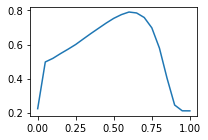

In [38]:
plt.figure(figsize=(3,2))
plt.plot(res['thrshes'], res['f1_lst'])  
plt.show()

In [39]:
preds_t = res['preds_best']

In [40]:
meanf1(preds_t, targets)

0.7907949361246561

In [42]:
from cuml.neighbors import NearestNeighbors
import numpy as np
import torch.nn.functional as F

N_NBRS=50
CHUNK=1024 * 4


def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS, metric="cosine")
    nnmdl.fit(feats)
    return nnmdl

def get_nbrs_from_nnmdl_rapidfeats(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype="float")
    idx = np.zeros((n, n_nbrs), dtype="int")
    n_chunks = len(feats) // sz_chunk
    if len(feats) % sz_chunk != 0:
        n_chunks += 1
    for j in tqdm(range(n_chunks)):
        a = j * sz_chunk
        b = (j + 1) * sz_chunk
        b = min(b, len(feats))
        dists_, idx_ = nnmdl.kneighbors(
            feats[
                a:b,
            ]
        )
        dists[a:b] = cupy.asnumpy(dists_)
        idx[a:b] = cupy.asnumpy(idx_)
    return dists, idx

def get_nbrs_rapidfeats(feats, n_nbrs=N_NBRS, sz_chunk=CHUNK):
    nnmdl = mk_nnmdl(feats, n_nbrs)
    dists, idx = get_nbrs_from_nnmdl_rapidfeats(feats, nnmdl, sz_chunk)
    return dists, idx 

In [43]:
nbrs = get_nbrs_rapidfeats(feats_txt)


100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


In [44]:
preds = get_preds_by_thrsh(*nbrs,thrsh=res['thrsh_best'])
preds_t = preds2pids(preds, pids)


In [45]:
meanf1(preds_t, targets)

0.7907949361246561

# setup

In [9]:
HOME = "/data/git/shopee-product-matching"
p_prp = f'{HOME}/output/prep002'

FOLD = 0
FP16 = True

import sys
sys.path.append(f"{HOME}/src")

import pandas as pd
from pl_model import ShpModel
import os
import torch
import numpy as np
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

from final import enet_arcface_FINAL, load_model

from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader


## utils

In [10]:
import numpy as np

def getf1(x, y):
    n = len(np.intersect1d(x, y))
    return 2 * n / (len(x) + len(y))


def getf1s(xs, ys):
    return (getf1(x, y) for x, y in zip(xs, ys))


def meanf1(xs, ys):
    return np.mean(list(getf1s(xs, ys)))


def get_targets(df):
    grp2ids = df.groupby("label_group").posting_id.agg("unique").to_dict()
    targets = df.label_group.map(grp2ids)
    return targets

def preds2pids(preds, pids):
    return [pids[o] for o in preds]


def comb_preds(*preds):
    return (np.unique(np.concatenate(l)) for l in zip(*preds))


# load model

In [11]:
ls trn*

trn0001--b1.ipynb
trn0002--b3-512.ipynb
trn0003--b4-512-fp16.ipynb
trn0004--use-prep002--b0--cv77--lb51.ipynb
trn0005--b1--cv76--lb55.ipynb
trn0005--b1--test-cosine.ipynb
trn0006--b3--cv75.ipynb
trn0007--b4--cv75.ipynb
trn0008--b1--max-eps10--cosine--cv75--lb51-65.ipynb
trn0008--b1--max-eps5--cosine--cv70.ipynb
trn0009--b5-512--cv76.ipynb
trn0010--b5--768--cv75.ipynb
trn0011--b6--768--cv73.ipynb
trn0012--b7--672--cv75.ipynb
trn0013--b3--768--cv74.ipynb
trn0014--b0--768--cv71.ipynb
trn0015--b0--512--cv76.ipynb
trn0016--b1--512--cv76.ipynb


In [12]:
ls ../output/trn*/tensorboard_csv/*/checkpoints/*.ckpt

'../output/trn0001/tensorboard_csv/0_0/checkpoints/epoch=29-step=12869.ckpt'
'../output/trn0002/tensorboard_csv/2_2/checkpoints/epoch=17-step=30833.ckpt'
'../output/trn0003/tensorboard_csv/5_5/checkpoints/epoch=21-step=37685.ckpt'
'../output/trn0004/tensorboard_csv/2_2/checkpoints/epoch=26-step=9827.ckpt'
'../output/trn0005/tensorboard_csv/0_0/checkpoints/epoch=23-step=8735.ckpt'
'../output/trn0006/tensorboard_csv/0_0/checkpoints/epoch=24-step=9099.ckpt'
'../output/trn0007/tensorboard_csv/0_0/checkpoints/epoch=23-step=34943.ckpt'
'../output/trn0008/tensorboard_csv/0_0/checkpoints/epoch=10-step=3640.ckpt'
'../output/trn0008/tensorboard_csv/1_1/checkpoints/epoch=5-step=1820.ckpt'
'../output/trn0009/tensorboard_csv/1_1/checkpoints/epoch=0-step=8.ckpt'
'../output/trn0009/tensorboard_csv/3_3/checkpoints/epoch=20-step=7643.ckpt'
'../output/trn0010/tensorboard_csv/0_0/checkpoints/epoch=19-step=7279.ckpt'
'../output/trn0011/tensorboard_csv/1_1/checkpoints/epoch=16-step=6187.ckpt'
'../output/tr

    trn0009--b5-512--cv76.ipynb
    trn0011--b6--768--cv73.ipynb
    trn0012--b7--672--cv75.ipynb
    trn0013--b3--768--cv74.ipynb
    trn0015--b0--512--cv76.ipynb

    '../output/trn0009/tensorboard_csv/3_3/checkpoints/epoch=20-step=7643.ckpt'
    '../output/trn0011/tensorboard_csv/1_1/checkpoints/epoch=16-step=6187.ckpt'
    '../output/trn0012/tensorboard_csv/6_6/checkpoints/epoch=15-step=7775.ckpt'
    '../output/trn0013/tensorboard_csv/0_0/checkpoints/epoch=21-step=8007.ckpt'
    '../output/trn0015/tensorboard_csv/1_1/checkpoints/epoch=17-step=13103.ckpt'

In [33]:
prfxs =  ["trn0009","trn0011","trn0012","trn0013","trn0015"] 
imgszes = [    512,     768,       672,      768,     512]
bss     = [     32,      16,        16,       32,      32]
enet_types=["tf_efficientnet_b5_ns", 
            "tf_efficientnet_b6_ns", 
            "tf_efficientnet_b7_ns",
            "tf_efficientnet_b3_ns",
            "tf_efficientnet_b0_ns",
           ]
ckpts = [
    '3_3/checkpoints/epoch=20-step=7643.ckpt',
    '1_1/checkpoints/epoch=16-step=6187.ckpt',
    '6_6/checkpoints/epoch=15-step=7775.ckpt',
    '0_0/checkpoints/epoch=21-step=8007.ckpt',
    '1_1/checkpoints/epoch=17-step=13103.ckpt',
]


In [14]:
df = pd.read_csv(f'{p_prp}/df_valid.csv')
pids = df.posting_id.values

targets = get_targets(df)

In [15]:
device = torch.device('cuda')
featss = []
for imdl in range(len(prfxs)):
    prfx = prfxs[imdl]
    imgsz = imgszes[imdl]
    enet_type = enet_types[imdl]
    ckpt = ckpts[imdl]
    bs = bss[imdl]
    shpmodel = ShpModel.load_from_checkpoint(f'{HOME}/output/{prfx}/tensorboard_csv/{ckpt}')
    out_dim = shpmodel.num_classes
    
    
    model = enet_arcface_FINAL(enet_type, out_dim=out_dim)
    model = load_model(model, shpmodel)
    model = model.to(device)
    
    
    
    tfms_trn, tfms_val = get_transforms(imgsz)
    ds = ShopeeDataset(df, mode="test", transform=tfms_val)
    dl = DataLoader(ds,
                batch_size=bs,
                num_workers=8,
                pin_memory=True,
            )

    feats = np.zeros((len(ds), 512))
    i = 0
    for dat in tqdm(dl):
        with torch.no_grad():
            dat = dat.to(device)
            feat,_ = model(dat)
            l = len(feat)
            feats[i : i + l, :] = feat.cpu().detach().numpy()
            i += l
            
    featss.append(feats)
    

0


100%|██████████| 321/321 [00:48<00:00,  6.67it/s]


1


100%|██████████| 321/321 [02:21<00:00,  2.27it/s]


2


100%|██████████| 321/321 [02:27<00:00,  2.17it/s]


3


100%|██████████| 321/321 [01:02<00:00,  5.12it/s]


4


100%|██████████| 321/321 [00:34<00:00,  9.24it/s]


In [16]:
len(featss)

5

# inference

In [17]:
from cuml.neighbors import NearestNeighbors
import numpy as np
import torch.nn.functional as F


N_NBRS = 50
CHUNK = 1024 * 4


def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS, metric="cosine")
    nnmdl.fit(feats)
    return nnmdl


def get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype="float")
    idx = np.zeros((n, n_nbrs), dtype="int")
    n_chunks = len(feats) // sz_chunk
    if len(feats) % sz_chunk != 0:
        n_chunks += 1
    for j in tqdm(range(n_chunks)):
        a = j * sz_chunk
        b = (j + 1) * sz_chunk
        b = min(b, len(feats))
        dists_, idx_ = nnmdl.kneighbors(
            feats[
                a:b,
            ]
        )
        dists[a:b] = np.array(dists_)
        idx[a:b] = np.array(idx_)
    return dists, idx


def get_nbrs(feats, n_nbrs=N_NBRS, sz_chunk=CHUNK):
    nnmdl = mk_nnmdl(feats, n_nbrs)
    dists, idx = get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk)
    return dists, idx


def get_preds_by_thrsh(dists, idx, thrsh):
    preds = (ind[dst < thrsh] for dst, ind in zip(dists, idx))
    return preds


def find_best(dists, idx, thrshes=np.linspace(0.,1.,num=21)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    res = {'f1_best': f1_best, 
           'thrsh_best': thrsh_best, 
           'preds_best': preds_best, 
           'thrshes': thrshes, 
           'f1_lst': f1_lst}
    return res

In [18]:
feats_conc = np.concatenate(featss, 1)
feats_conc = F.normalize(torch.tensor(feats_conc))
feats_conc = feats_conc.numpy()

In [19]:
feats_conc.shape

(5135, 2560)

In [20]:
nbrs = get_nbrs(feats_conc)

100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


In [21]:
dists, idx = nbrs
res = find_best(dists, idx)
print(f"{res['f1_best']:.3f}, {res['thrsh_best']:.2f} ")

100%|██████████| 21/21 [00:04<00:00,  4.98it/s]

0.774, 0.55 


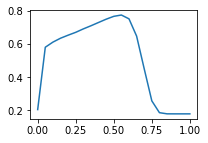

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(res['thrshes'], res['f1_lst'])  
plt.show()

In [23]:
preds_v = res['preds_best']

In [24]:
meanf1(preds_v, targets)

0.773531528817632

In [25]:
preds_v[:30]

[array(['train_1802986387'], dtype=object),
 array(['train_1806152124'], dtype=object),
 array(['train_3009013664', 'train_3448377589'], dtype=object),
 array(['train_2985955659', 'train_4156734436', 'train_3916258742'],
       dtype=object),
 array(['train_2238403912', 'train_2095062361', 'train_2783619727'],
       dtype=object),
 array(['train_1180155871'], dtype=object),
 array(['train_3466601092', 'train_354147588'], dtype=object),
 array(['train_3117535609', 'train_1572286671', 'train_3219773229'],
       dtype=object),
 array(['train_3117535609', 'train_1572286671', 'train_3219773229'],
       dtype=object),
 array(['train_1617041019'], dtype=object),
 array(['train_3697474443', 'train_942029375', 'train_2003670906'],
       dtype=object),
 array(['train_3350934785', 'train_1675185549'], dtype=object),
 array(['train_363659042', 'train_4224125539', 'train_3155443042'],
       dtype=object),
 array(['train_3122040273', 'train_1665497995'], dtype=object),
 array(['train_3286978516

# hsh

In [26]:
def get_preds_pids_h(df):
    hsh2ids = df.groupby("image_phash").posting_id.agg("unique").to_dict()
    preds_h = df.image_phash.map(hsh2ids)
    return preds_h

In [27]:
preds_h = get_preds_pids_h(df)

In [28]:
meanf1(preds_h, targets)

0.5415179652897422

# combine

In [46]:
preds_comb = list(comb_preds(preds_v, preds_t))

meanf1(preds_comb, targets)

0.833691291016458

In [47]:
preds_comb[:30]

[array(['train_1396161074', 'train_1802986387', 'train_2490201622'],
       dtype=object),
 array(['train_1806152124'], dtype=object),
 array(['train_1248209230', 'train_2047191940', 'train_236461645',
        'train_3009013664', 'train_3448377589', 'train_599478601'],
       dtype=object),
 array(['train_1981120792', 'train_2985955659', 'train_3916258742',
        'train_4156734436'], dtype=object),
 array(['train_2095062361', 'train_2238403912', 'train_2254345921',
        'train_2783619727'], dtype=object),
 array(['train_1180155871', 'train_3269870940'], dtype=object),
 array(['train_1740344938', 'train_3466601092', 'train_354147588'],
       dtype=object),
 array(['train_1572286671', 'train_3117535609', 'train_3219773229'],
       dtype=object),
 array(['train_1572286671', 'train_3117535609', 'train_3219773229'],
       dtype=object),
 array(['train_1617041019', 'train_2772927896'], dtype=object),
 array(['train_2003670906', 'train_3697474443', 'train_942029375'],
       dtype=obj

In [48]:
preds_comb = comb_preds(preds_v, preds_t, preds_h)

meanf1(preds_comb, targets)

0.8336023777570675

# fin

In [32]:
!nvidia-smi

Thu Apr 15 02:21:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   50C    P0    52W / 300W |  12260MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  